In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Load data
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [3]:
y_train = train['label']
X_train = train.drop(labels = ['label'], axis=1)
del train

In [4]:
# grayscale normalization
X_train = X_train / 255.0
test = test / 255.0

# reshape image in 3 dimension
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [5]:
# encode labels to one hot vectors
y_train = to_categorical(y_train, num_classes=10)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =0.1, random_state=2)

In [21]:
X_train.shape

(37800, 28, 28, 1)

In [7]:
# set the CNN model
# [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [8]:
# set the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [9]:
#compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
epochs = 10
batch_size = 86

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center= False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=10,  #randomly rotate image in 0 to 180 degree
            zoom_range=0.1, #randomly zoom image
            width_shift_range=0.1, #randomly shift images horizontally
            height_shift_range=0.1, #randomly shift images vertically
            horizontal_flip = False, #randomly flip images
            vertical_flip = False #randomly flip images
)
datagen.fit(X_train)

In [12]:
# Fit the model
clf = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                          epochs=1, validation_data=(X_val, y_val), verbose=2, 
                          steps_per_epoch=X_train.shape[0] // batch_size, 
                          callbacks=[learning_rate_reduction])

Epoch 1/1
 - 354s - loss: 0.4065 - acc: 0.8686 - val_loss: 0.0643 - val_acc: 0.9810


In [15]:
model.save('mnist_keras_cnn_model.h5')

In [16]:
from keras.models import load_model
model = load_model('mnist_keras_cnn_model.h5')

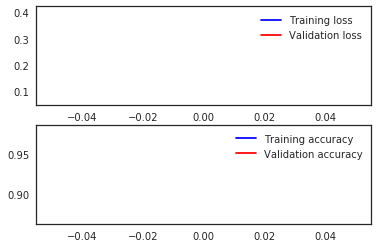

In [20]:
# plot the loss and accuracy curves
fig, ax = plt.subplots(2,1)
ax[0].plot(clf.history['loss'], color='b', label='Training loss')
ax[0].plot(clf.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(clf.history['acc'], color='b', label='Training accuracy')
ax[1].plot(clf.history['val_acc'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow=True)